In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp311-cp311-linux_x86_64.whl size=551661 sha256=7bf3ac5a8f74e01b5ee90c7d4e655a1234e5977486a7542a2b2684e0e58197fc
  Stored in directory: /root/.cache/pip/wheels/33/e5/58/0a3e34b92bedf09b4c57e37a63ff395ade6f6c1099ba59877c
Successfully built annoy


## **Importing Neccessary Libraries**

In [16]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.models import Model
from annoy import AnnoyIndex
from PIL import Image
import matplotlib.pyplot as plt

## **Feature Extraction from Images using Pre-trained Models**

In [17]:
def angular_distance(vec1, vec2):
    """Compute angular distance and cosine similarity between two vectors."""
    vec1_norm = vec1 / np.linalg.norm(vec1)
    vec2_norm = vec2 / np.linalg.norm(vec2)
    cosine_sim = np.dot(vec1_norm, vec2_norm)
    angular_dist = np.sqrt(2 * (1 - cosine_sim))
    return angular_dist, cosine_sim

def extract_features(model_path, image_dir, layer_name="dense"):
    """Extract features for all images in a directory."""
    model = tf.keras.models.load_model(model_path, compile=False)
    dummy_input = tf.zeros((1, 224, 224, 3))
    _ = model(dummy_input)
    feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer(name=layer_name).output)
    image_paths, features = [], []
    for img_name in sorted(os.listdir(image_dir)):
        img_path = os.path.join(image_dir, img_name)
        try:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            if layer_name == "dense":
                img_array = tf.keras.applications.resnet.preprocess_input(img_array)
            else:
                img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
            feature_vec = feature_extractor.predict(img_array, verbose=0)[0]
            image_paths.append(img_path)
            features.append(feature_vec)
        except Exception as e:
            print(f"Error processing {img_name}: {e}")
    return image_paths, np.array(features)


## **Building & Querying the Annoy Index**

In [18]:

def save_features_and_index(features, image_paths, index_path, annoy_path):
    """Save features and build Annoy index."""
    np.save(index_path, features)
    with open(index_path.replace('.npy', '_paths.txt'), 'w') as f:
        for path in image_paths:
            f.write(path + '\n')
    annoy_index = AnnoyIndex(features.shape[1], 'angular')
    for i, feat in enumerate(features):
        annoy_index.add_item(i, feat)
    annoy_index.build(100)
    annoy_index.save(annoy_path)

def load_features_and_index(index_path, annoy_path):
    """Load features, image paths, and Annoy index."""
    features = np.load(index_path)
    with open(index_path.replace('.npy', '_paths.txt')) as f:
        image_paths = [line.strip() for line in f]
    annoy_index = AnnoyIndex(features.shape[1], 'angular')
    annoy_index.load(annoy_path)
    return features, image_paths, annoy_index

def get_query_feature(model_path, query_img_path, layer_name="dense"):
    """Extract feature vector for a query image."""
    model = tf.keras.models.load_model(model_path, compile=False)
    dummy_input = tf.zeros((1, 224, 224, 3))
    _ = model(dummy_input)
    feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer(name=layer_name).output)
    img = tf.keras.preprocessing.image.load_img(query_img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    if layer_name == "dense":
        img_array = tf.keras.applications.resnet.preprocess_input(img_array)
    else:
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return feature_extractor.predict(img_array, verbose=0)[0]

In [19]:
MODEL_PATH_RESNET = "/content/best_resnet_finetuned.keras"
MODEL_PATH_EFFICIENTNET = "/content/best_efficientnet_finetuned.keras"
IMAGE_DIR = "/content/drive/MyDrive/nga_data/images"
INDEX_PATH_RESNET = "/content/drive/MyDrive/nga_data/resnet_annoy.ann"
Numpy_PATH_RESNET="/content/drive/MyDrive/nga_data/resnet_features.npy"
Numpy_PATH_EFFICIENTNET="/content/drive/MyDrive/nga_data/efficientnet_features.npy"
INDEX_PATH_EFFICIENTNET = "/content/drive/MyDrive/nga_data/efficientnet_annoy.ann"
QUERY_IMAGE_PATH = "/content/drive/MyDrive/nga_data/images/42933.jpg"

# Example usage (do this ONCE for each model)
image_paths, features = extract_features(MODEL_PATH_RESNET, IMAGE_DIR, layer_name="dense")
save_features_and_index(features, image_paths, Numpy_PATH_RESNET, INDEX_PATH_RESNET)

image_paths, features = extract_features(MODEL_PATH_EFFICIENTNET, IMAGE_DIR, layer_name="dense_2")
save_features_and_index(features, image_paths, Numpy_PATH_EFFICIENTNET, INDEX_PATH_EFFICIENTNET)

## **Plotting Similar Images from National Gallery of Art(NGA) Dataset for given any Query Image**

In [26]:
def show_similar_images(query_img_path, similar_paths, angular_distances, cosine_similarities, model_name=""):
    """Display query and similar images with improved aesthetics."""
    num_images = len(similar_paths) + 1
    fig, axes = plt.subplots(1, num_images, figsize=(4 * num_images, 6))

    # Query image
    axes[0].imshow(Image.open(query_img_path))
    axes[0].set_title(f"Query Image\n{model_name}", fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Similar images with metrics
    for i, (img_path, ang_dist, cos_sim) in enumerate(zip(similar_paths, angular_distances, cosine_similarities), start=1):
        axes[i].imshow(Image.open(img_path))
        axes[i].set_title(
            f"Rank {i}\nAngDist: {ang_dist:.3f}\nCosSim: {cos_sim:.3f}",
            fontsize=12
        )
        axes[i].axis('off')

    plt.suptitle(f"Similarity Search Results - {model_name}", fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

def search_similar_images(query_img_path, model_path, index_path, annoy_path, top_k=5, layer_name="dense", model_name=""):
    features, image_paths, annoy_index = load_features_and_index(index_path, annoy_path)
    query_feature = get_query_feature(model_path, query_img_path, layer_name=layer_name)
    similar_indices, annoy_dists = annoy_index.get_nns_by_vector(query_feature, top_k + 1, include_distances=True)
    similar_paths, angular_dists, cosine_sims = [], [], []
    for idx in similar_indices:
        img_path = image_paths[idx]
        if os.path.basename(img_path) != os.path.basename(query_img_path):
            similar_paths.append(img_path)
            ang_dist, cos_sim = angular_distance(query_feature, features[idx])
            angular_dists.append(ang_dist)
            cosine_sims.append(cos_sim)
            print(f"{os.path.basename(img_path)} | AngDist: {ang_dist:.4f} | CosSim: {cos_sim:.4f}")
    show_similar_images(query_img_path, similar_paths[:top_k], angular_dists[:top_k], cosine_sims[:top_k], model_name=model_name)
    print(f"Avg Angular Distance: {np.mean(angular_dists[:top_k]):.4f}")
    print(f"Avg Cosine Similarity: {np.mean(cosine_sims[:top_k]):.4f}")
    return angular_dists[:top_k], cosine_sims[:top_k]


## **Function to Print Similarity Statistics for ResNet and EfficientNet**

In [30]:
def print_both_similarity_stats(angular_dists_resnet, cosine_sims_resnet, angular_dists_efficientnet, cosine_sims_efficientnet):
    """
    Print average and standard deviation for angular distances and cosine similarities for both models.
    """
    print("ResNet Similarity Statistics:")
    print(f"  Average Angular Distance: {np.mean(angular_dists_resnet):.4f}")
    print(f"  Std Dev Angular Distance: {np.std(angular_dists_resnet):.4f}")
    print(f"  Average Cosine Similarity: {np.mean(cosine_sims_resnet):.4f}")
    print(f"  Std Dev Cosine Similarity: {np.std(cosine_sims_resnet):.4f}")
    print()
    print("EfficientNet Similarity Statistics:")
    print(f"  Average Angular Distance: {np.mean(angular_dists_efficientnet):.4f}")
    print(f"  Std Dev Angular Distance: {np.std(angular_dists_efficientnet):.4f}")
    print(f"  Average Cosine Similarity: {np.mean(cosine_sims_efficientnet):.4f}")
    print(f"  Std Dev Cosine Similarity: {np.std(cosine_sims_efficientnet):.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


42921.jpg | AngDist: 0.3261 | CosSim: 0.9468
56913.jpg | AngDist: 0.3610 | CosSim: 0.9349
1114.jpg | AngDist: 0.3637 | CosSim: 0.9339
84377.jpg | AngDist: 0.3894 | CosSim: 0.9242
99.jpg | AngDist: 0.3922 | CosSim: 0.9231


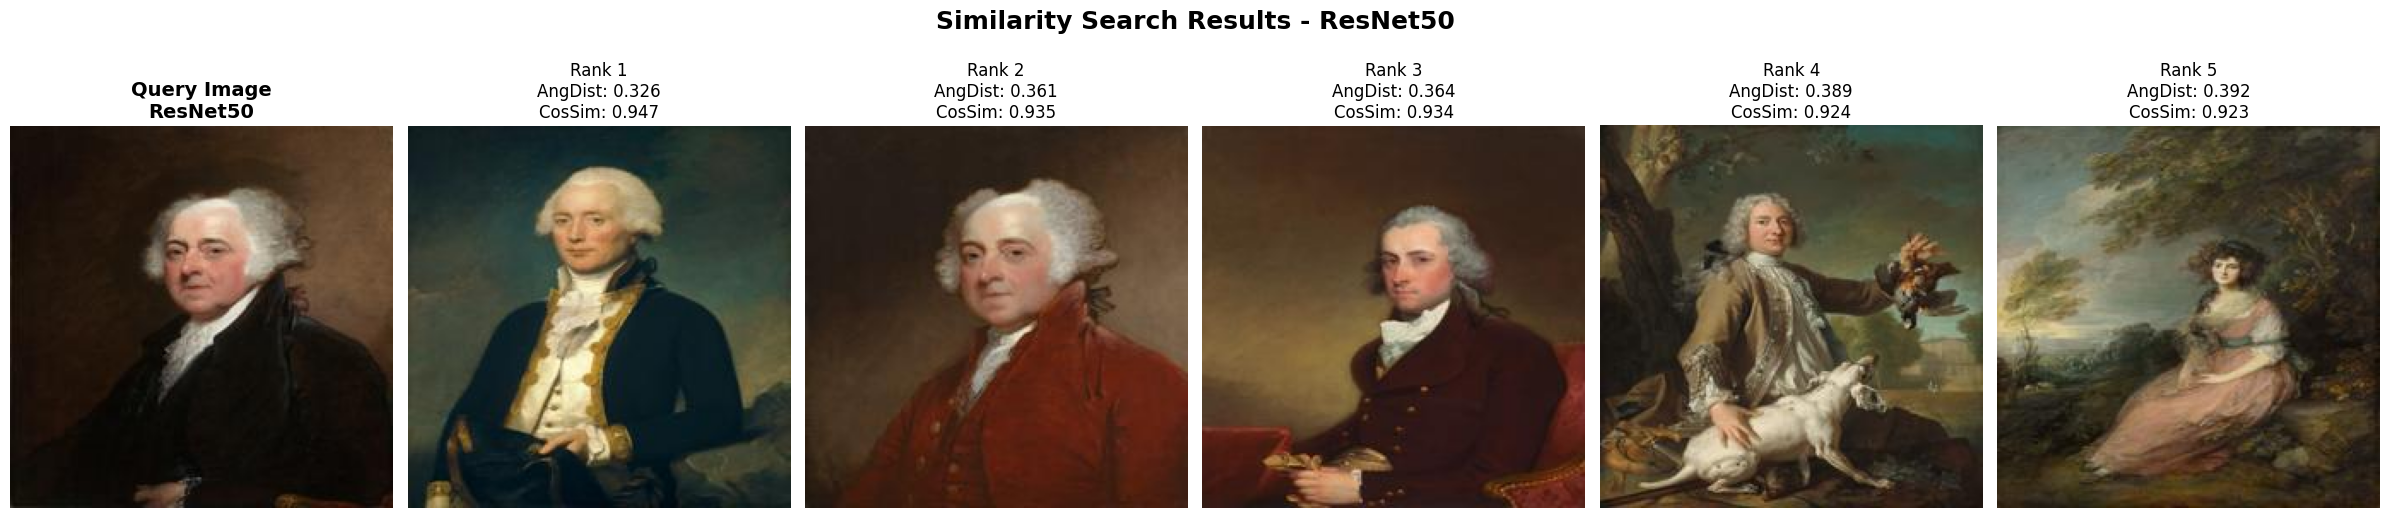

Avg Angular Distance: 0.3665
Avg Cosine Similarity: 0.9326


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_3']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


499.jpg | AngDist: 0.5821 | CosSim: 0.8306
131993.jpg | AngDist: 0.6852 | CosSim: 0.7653
34136.jpg | AngDist: 0.7384 | CosSim: 0.7274
46095.jpg | AngDist: 0.7455 | CosSim: 0.7221
1121.jpg | AngDist: 0.7531 | CosSim: 0.7164


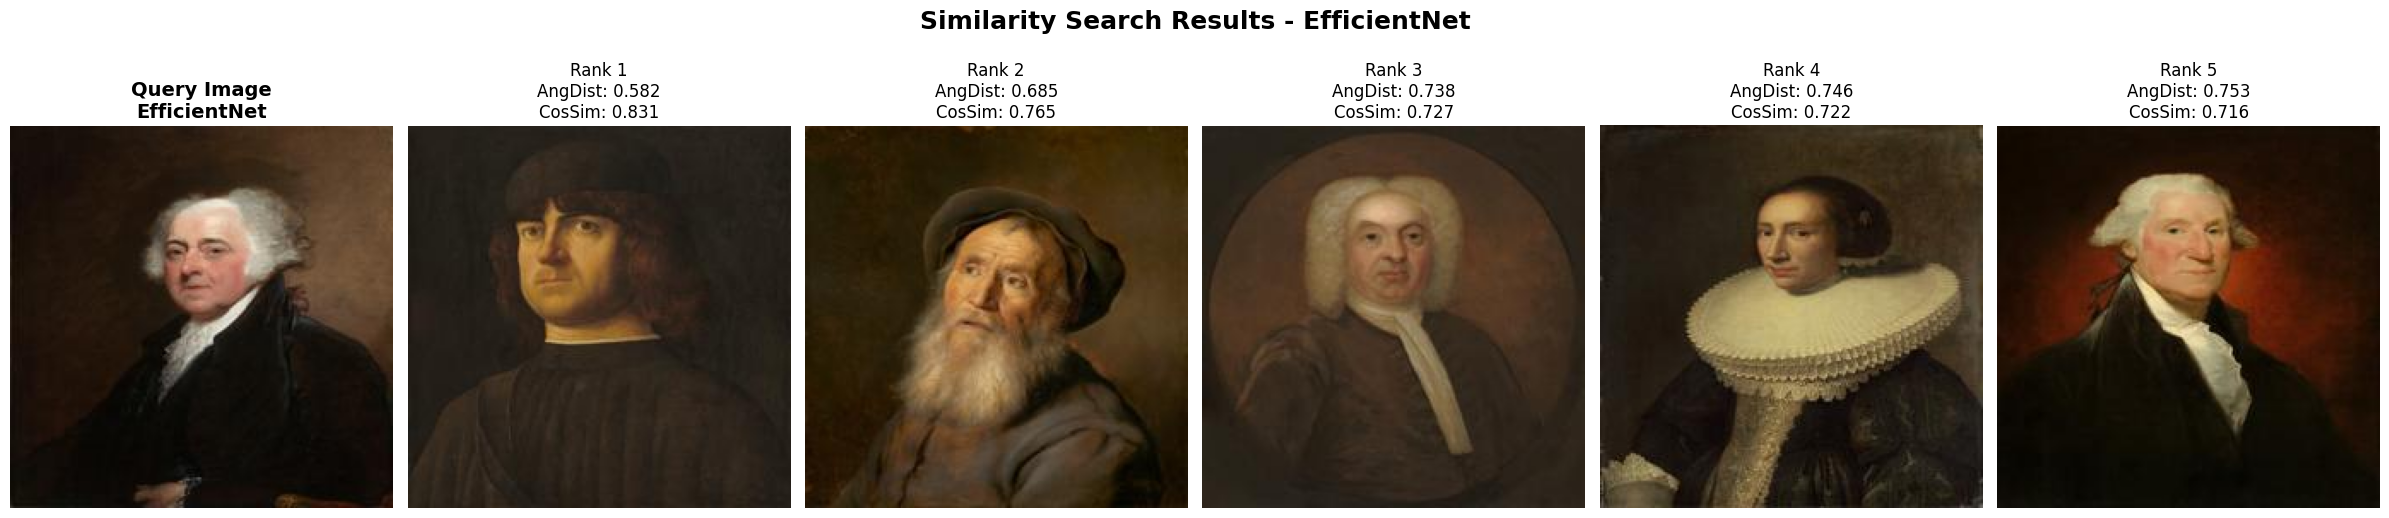

Avg Angular Distance: 0.7009
Avg Cosine Similarity: 0.7524


In [27]:
QUERY_IMAGE_PATH = "/content/drive/MyDrive/nga_data/images/42933.jpg"
angular_dists_resnet, cosine_sims_resnet = search_similar_images(
    QUERY_IMAGE_PATH,
    MODEL_PATH_RESNET,
    Numpy_PATH_RESNET,
    INDEX_PATH_RESNET,
    top_k=5,
    layer_name="dense",
    model_name="ResNet50"
)


angular_dists_efficientnet, cosine_sims_efficientnet = search_similar_images(
    QUERY_IMAGE_PATH,
    MODEL_PATH_EFFICIENTNET,
    Numpy_PATH_EFFICIENTNET,
    INDEX_PATH_EFFICIENTNET,
    top_k=5,
    layer_name="dense_2",
    model_name="EfficientNet"
)


In [31]:
print_both_similarity_stats(angular_dists_resnet, cosine_sims_resnet, angular_dists_efficientnet, cosine_sims_efficientnet)

ResNet Similarity Statistics:
  Average Angular Distance: 0.3665
  Std Dev Angular Distance: 0.0239
  Average Cosine Similarity: 0.9326
  Std Dev Cosine Similarity: 0.0086

EfficientNet Similarity Statistics:
  Average Angular Distance: 0.7009
  Std Dev Angular Distance: 0.0640
  Average Cosine Similarity: 0.7524
  Std Dev Cosine Similarity: 0.0427


67518.jpg | AngDist: 0.5216 | CosSim: 0.8640
86855.jpg | AngDist: 0.5301 | CosSim: 0.8595
56721.jpg | AngDist: 0.5444 | CosSim: 0.8518
67433.jpg | AngDist: 0.5473 | CosSim: 0.8502
103850.jpg | AngDist: 0.5531 | CosSim: 0.8471


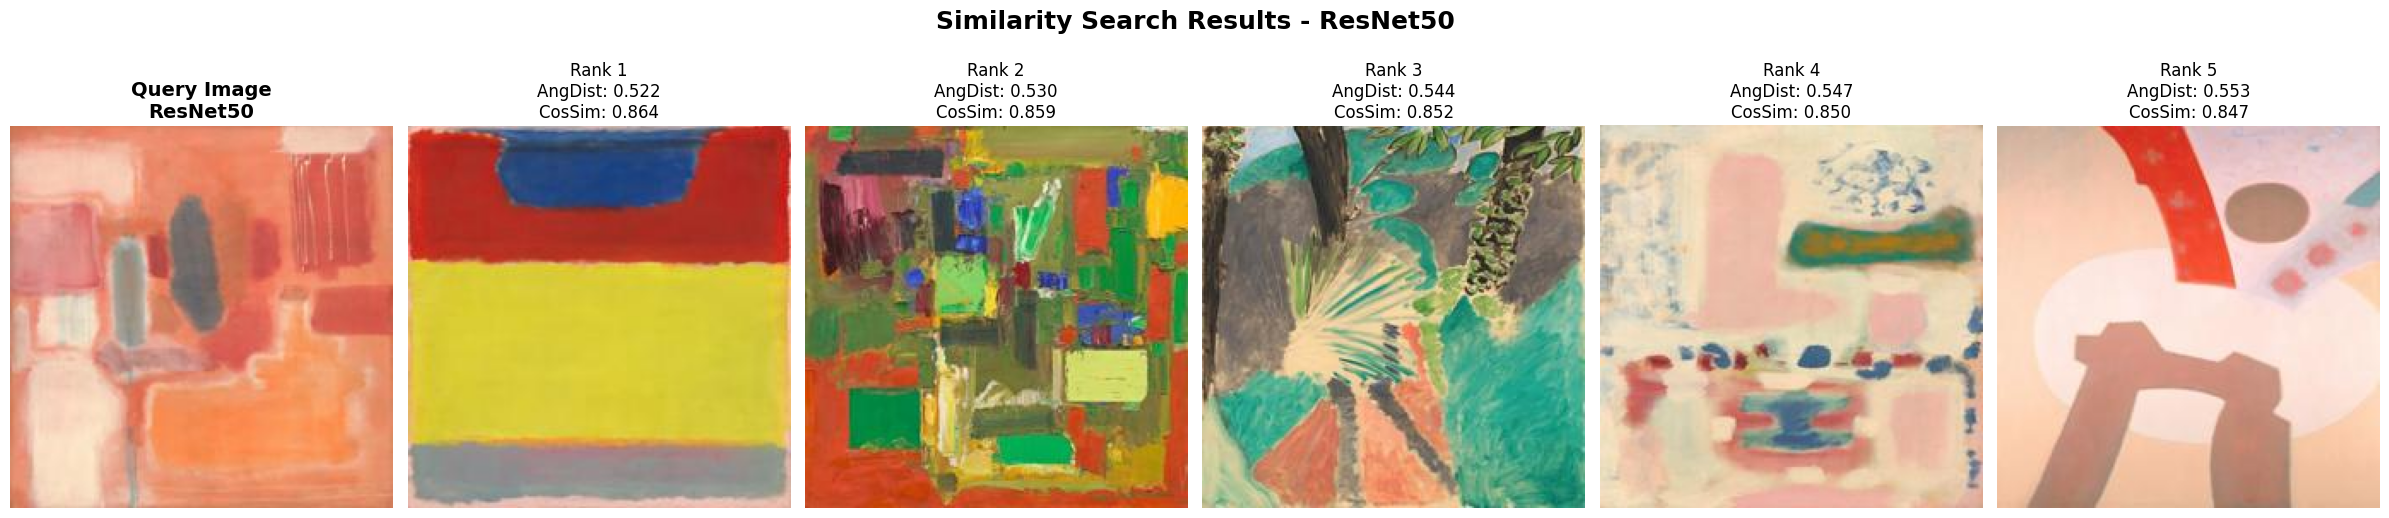

Avg Angular Distance: 0.5393
Avg Cosine Similarity: 0.8545


136022.jpg | AngDist: 0.8201 | CosSim: 0.6637
69388.jpg | AngDist: 0.8237 | CosSim: 0.6607
67503.jpg | AngDist: 0.8311 | CosSim: 0.6546
163525.jpg | AngDist: 0.8568 | CosSim: 0.6329
136020.jpg | AngDist: 0.8633 | CosSim: 0.6273


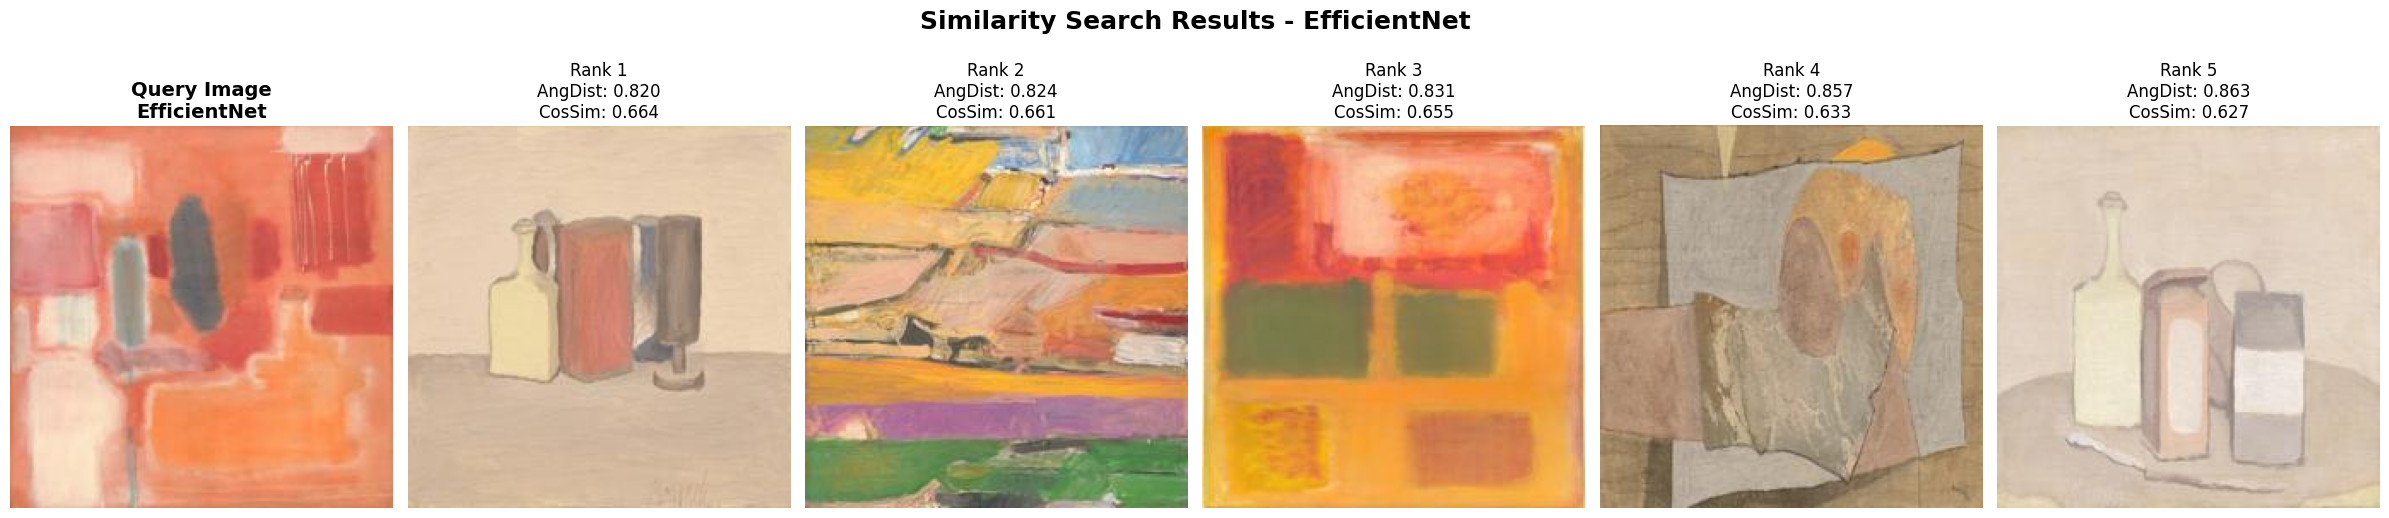

Avg Angular Distance: 0.8390
Avg Cosine Similarity: 0.6479


In [32]:
QUERY_IMAGE_PATH = "/content/drive/MyDrive/nga_data/images/67501.jpg"
angular_dists_resnet, cosine_sims_resnet = search_similar_images(
    QUERY_IMAGE_PATH,
    MODEL_PATH_RESNET,
    Numpy_PATH_RESNET,
    INDEX_PATH_RESNET,
    top_k=5,
    layer_name="dense",
    model_name="ResNet50"
)


angular_dists_efficientnet, cosine_sims_efficientnet = search_similar_images(
    QUERY_IMAGE_PATH,
    MODEL_PATH_EFFICIENTNET,
    Numpy_PATH_EFFICIENTNET,
    INDEX_PATH_EFFICIENTNET,
    top_k=5,
    layer_name="dense_2",
    model_name="EfficientNet"
)



In [33]:
print_both_similarity_stats(angular_dists_resnet, cosine_sims_resnet, angular_dists_efficientnet, cosine_sims_efficientnet)

ResNet Similarity Statistics:
  Average Angular Distance: 0.5393
  Std Dev Angular Distance: 0.0116
  Average Cosine Similarity: 0.8545
  Std Dev Cosine Similarity: 0.0062

EfficientNet Similarity Statistics:
  Average Angular Distance: 0.8390
  Std Dev Angular Distance: 0.0177
  Average Cosine Similarity: 0.6479
  Std Dev Cosine Similarity: 0.0149
